In [37]:
import pickle
import pandas as pd
import numpy as np


%matplotlib inline
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from collections import defaultdict



Building the model

Load test split set

In [3]:
with open('split_data.pkl', 'rb') as f:
    split_data = pickle.load(f)
(X, X_holdout, y, y_holdout) = split_data

Get rid of all the NaN

In [4]:
X.Skills.fillna('',inplace=True)
X_holdout.Skills.fillna('',inplace=True)
X['product'].fillna('',inplace=True)
X_holdout['product'].fillna('',inplace=True)

Make a train validation set for test purpose. Take out 15% for validation

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1765, random_state=21)

In [6]:
from sklearn.metrics import mean_squared_error
def RMSE(actual, predicted):
    return np.sqrt(mean_squared_error(actual,predicted))

In [7]:
def test_model(model, X, y, X_val, y_val, alpha=None):
    '''test different sklearn models.
    '''
    if alpha:
        lm = model(alpha)
    else:
        lm = model()
    lm.fit(X,y)
    print(alpha,  'val R^2: %.5f' % lm.score(X_val, y_val))
    return (lm, lm.score(X_val, y_val))

In [8]:
def cross_validation_v2(X, y, model_list=None, alphas=None, cv=5):
    if not alphas:
        alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    if not model_list:
        model_list = [LinearRegression, Ridge, Lasso]
        
    kf = KFold(n_splits=cv, shuffle=True)
    
    if type(X) == pd.core.frame.DataFrame:
        X = X.values

    for model in model_list:
        print('model:', model)
        r2 = []
        if model != LinearRegression:
            scaler = StandardScaler()
            #X_train = scaler.fit_transform(X_train)
            #X_val = scaler.transform(X_val)
            for a in alphas:
                r2 = []
                for train_ind, val_ind in kf.split(X,y):
                    X_train, y_train = X[train_ind], y.iloc[train_ind]
                    X_val, y_val = X[val_ind], y.iloc[val_ind]
                    
                    scaler = StandardScaler()
                    X_train = scaler.fit_transform(X_train)
                    X_val = scaler.transform(X_val)
                    
                    _, score = test_model(model, X_train, y_train, X_val, y_val, alpha=a)
                    r2.append(score)
                print('lambda %f, mean cv r^2: %.3f +- %.3f'%(a, np.mean(r2),np.std(r2)))
        else:       
            for train_ind, val_ind in kf.split(X,y):
                X_train, y_train = X[train_ind], y.iloc[train_ind]
                X_val, y_val = X[val_ind], y.iloc[val_ind]

                _, score = test_model(model, X_train, y_train, X_val, y_val, alpha=None)
                r2.append(score)
            print('mean cv r^2: %.3f +- %.3f'%(np.mean(r2),np.std(r2)))
   
          

#### Try simple linear regression

In [9]:
lm_features = ['401k','experience', 'free_food','insurance', 'visa', 'employees', 'investors',
       'open_jobs',  'size_', 'size_1-10', 'size_11-50',
       'size_201-500', 'size_51-200', 'degree_bs', 'degree_ms', 'degree_phd',
       'equity_low', 'equity_high',  'type_Contract',
       'type_Full Time', 'type_Internship']

In [10]:
lm = LinearRegression()
lm.fit(X_train[lm_features], y_train)
print('Linear Regression val R^2: %.3f', lm.score(X_val[lm_features], y_val))

Linear Regression val R^2: %.3f 0.20378864661161356


In [11]:
for i, j in zip(X_train[lm_features].columns, lm.coef_):
    print(i, j)

401k 9451.753644101815
experience 4145.921380761541
free_food -11517.663121257032
insurance 5054.488687769132
visa 7682.604603581771
employees 820.1254874299684
investors 348.42970502343996
open_jobs -819.6649758715998
size_ -3196.198959631798
size_1-10 -7611.644107421838
size_11-50 340.29888528425727
size_201-500 15447.5711130369
size_51-200 -4980.026931267296
degree_bs 3948.729276341954
degree_ms 8571.76700440337
degree_phd 16684.574350458097
equity_low -2786.643441728797
equity_high -311.2043309123974
type_Contract -25587.199732269793
type_Full Time -9414.308928208604
type_Internship -57283.79565599041


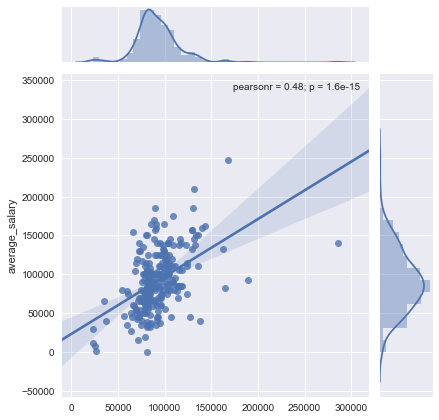

In [12]:
y_pred = lm.predict(X_val[lm_features])
sns.set()
sns.jointplot(y_pred,y_val, kind='regplot');

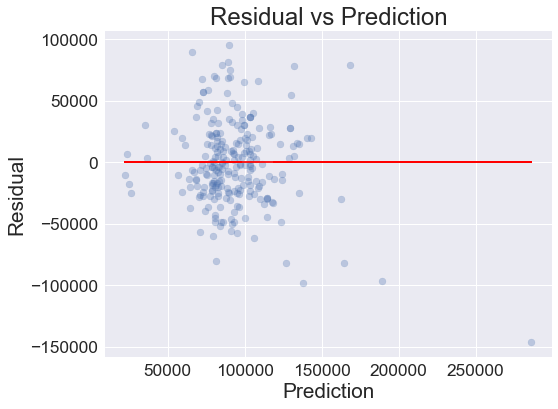

In [13]:
plt.figure(figsize = (8, 6))
plt.scatter(y_pred, y_val-y_pred, alpha=0.3)
plt.plot(y_pred, [0]*len(y_pred), 'r')
plt.title('Residual vs Prediction', fontsize=24)
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.xlabel('Prediction', fontsize='xx-large')
plt.ylabel('Residual',fontsize='xx-large');

In [14]:
print(RMSE(y_val, y_pred))

34882.799332781986


Try to see if regularization help improve the model

In [15]:
cross_validation_v2(X[lm_features],y, [LinearRegression, Ridge, Lasso], [0.01, 0.1, 1, 10, 100, 1000], cv=5)

model: <class 'sklearn.linear_model.base.LinearRegression'>
None val R^2: 0.21337
None val R^2: 0.25046
None val R^2: 0.14828
None val R^2: 0.21397
None val R^2: 0.21966
mean cv r^2: 0.209 +- 0.033
model: <class 'sklearn.linear_model.ridge.Ridge'>
0.01 val R^2: 0.23689
0.01 val R^2: 0.13773
0.01 val R^2: 0.19845
0.01 val R^2: 0.16775
0.01 val R^2: 0.28562
lambda 0.010000, mean cv r^2: 0.205 +- 0.052
0.1 val R^2: 0.18090
0.1 val R^2: 0.14950
0.1 val R^2: 0.26138
0.1 val R^2: 0.26358
0.1 val R^2: 0.22585
lambda 0.100000, mean cv r^2: 0.216 +- 0.045
1 val R^2: 0.16221
1 val R^2: 0.23872
1 val R^2: 0.24720
1 val R^2: 0.20003
1 val R^2: 0.21766
lambda 1.000000, mean cv r^2: 0.213 +- 0.030
10 val R^2: 0.21444
10 val R^2: 0.23590
10 val R^2: 0.20543
10 val R^2: 0.26100
10 val R^2: 0.17355
lambda 10.000000, mean cv r^2: 0.218 +- 0.029
100 val R^2: 0.18052
100 val R^2: 0.15567
100 val R^2: 0.27931
100 val R^2: 0.22723
100 val R^2: 0.25918
lambda 100.000000, mean cv r^2: 0.220 +- 0.046
1000 val 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.01 val R^2: 0.17423
lambda 0.010000, mean cv r^2: 0.215 +- 0.024
0.1 val R^2: 0.21976
0.1 val R^2: 0.21824
0.1 val R^2: 0.22434
0.1 val R^2: 0.19561
0.1 val R^2: 0.25842
lambda 0.100000, mean cv r^2: 0.223 +- 0.020
1 val R^2: 0.21270
1 val R^2: 0.17510
1 val R^2: 0.16358
1 val R^2: 0.21313
1 val R^2: 0.24051
lambda 1.000000, mean cv r^2: 0.201 +- 0.028
10 val R^2: 0.19592
10 val R^2: 0.18334
10 val R^2: 0.26539
10 val R^2: 0.25186
10 val R^2: 0.14804
lambda 10.000000, mean cv r^2: 0.209 +- 0.044
100 val R^2: 0.19271
100 val R^2: 0.24056
100 val R^2: 0.19354
100 val R^2: 0.23194
100 val R^2: 0.22741
lambda 100.000000, mean cv r^2: 0.217 +- 0.020
1000 val R^2: 0.20451
1000 val R^2: 0.21373
1000 val R^2: 0.22221
1000 val R^2: 0.22442
1000 val R^2: 0.21301
lambda 1000.000000, mean cv r^2: 0.216 +- 0.007


Regularization doens't improve R2. It seems like that the model is too biased.
#### Try log transform of the skewed features

In [16]:
def log_transform(df, colname_list):
    df_log = df.copy()
    for col in colname_list:
        colname = col + '_log'
        df_log[colname] = np.log(df[col])
    df_log.drop(columns = colname_list, inplace=True)   
    return df_log

In [17]:
X_log = log_transform(X[lm_features], ['employees', 'investors'] )
X_log['experience_log'] = np.log(X['experience']+1) #Some values in experience is zero

In [18]:
cross_validation_v2(X_log,y, [LinearRegression, Ridge, Lasso], [0.01, 0.1, 1, 10, 100, 1000], cv=5)

model: <class 'sklearn.linear_model.base.LinearRegression'>
None val R^2: 0.13062
None val R^2: 0.21016
None val R^2: 0.33851
None val R^2: 0.31601
None val R^2: 0.19345
mean cv r^2: 0.238 +- 0.078
model: <class 'sklearn.linear_model.ridge.Ridge'>
0.01 val R^2: 0.27538
0.01 val R^2: 0.20232
0.01 val R^2: 0.23300
0.01 val R^2: 0.29186
0.01 val R^2: 0.16558
lambda 0.010000, mean cv r^2: 0.234 +- 0.046
0.1 val R^2: 0.15604
0.1 val R^2: 0.27151
0.1 val R^2: 0.27773
0.1 val R^2: 0.26661
0.1 val R^2: 0.20988
lambda 0.100000, mean cv r^2: 0.236 +- 0.047
1 val R^2: 0.28807
1 val R^2: 0.21197
1 val R^2: 0.07651
1 val R^2: 0.28322
1 val R^2: 0.33046
lambda 1.000000, mean cv r^2: 0.238 +- 0.089
10 val R^2: 0.19979
10 val R^2: 0.17094
10 val R^2: 0.25283
10 val R^2: 0.25906
10 val R^2: 0.27489
lambda 10.000000, mean cv r^2: 0.232 +- 0.039
100 val R^2: 0.28797
100 val R^2: 0.17883
100 val R^2: 0.28755
100 val R^2: 0.22681
100 val R^2: 0.21455
lambda 100.000000, mean cv r^2: 0.239 +- 0.043
1000 val 

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.1 val R^2: 0.28927
0.1 val R^2: 0.17428
0.1 val R^2: 0.19620
0.1 val R^2: 0.29699
0.1 val R^2: 0.22502
lambda 0.100000, mean cv r^2: 0.236 +- 0.049
1 val R^2: 0.24927
1 val R^2: 0.24895
1 val R^2: 0.23655
1 val R^2: 0.24996
1 val R^2: 0.17213
lambda 1.000000, mean cv r^2: 0.231 +- 0.030
10 val R^2: 0.22686
10 val R^2: 0.29715
10 val R^2: 0.17519
10 val R^2: 0.22199
10 val R^2: 0.26305
lambda 10.000000, mean cv r^2: 0.237 +- 0.041
100 val R^2: 0.19686
100 val R^2: 0.18966
100 val R^2: 0.20243
100 val R^2: 0.31944
100 val R^2: 0.29737
lambda 100.000000, mean cv r^2: 0.241 +- 0.056
1000 val R^2: 0.29005
1000 val R^2: 0.21022
1000 val R^2: 0.24053
1000 val R^2: 0.19688
1000 val R^2: 0.18994
lambda 1000.000000, mean cv r^2: 0.226 +- 0.037


Log Transformation improved the model a little bit, but not impressive.
#### Try add interaction to the model

In [19]:
interactions = PolynomialFeatures(degree=2, interaction_only=True)
X_interaction = interactions.fit_transform(X[lm_features])

In [20]:
cross_validation_v2(X_interaction, y, [LinearRegression, Ridge, Lasso], [100,500,600,700,1000,2000, 5000,7000], cv=5)

model: <class 'sklearn.linear_model.base.LinearRegression'>
None val R^2: 0.01775
None val R^2: -43273.35937
None val R^2: -0.21771
None val R^2: -0.15784
None val R^2: -2.99531
mean cv r^2: -8655.342 +- 17309.008
model: <class 'sklearn.linear_model.ridge.Ridge'>
100 val R^2: -5.57447
100 val R^2: 0.17461
100 val R^2: 0.16354
100 val R^2: 0.24282
100 val R^2: 0.18999
lambda 100.000000, mean cv r^2: -0.961 +- 2.307
500 val R^2: 0.15985
500 val R^2: 0.27791
500 val R^2: 0.01615
500 val R^2: 0.31116
500 val R^2: -1.97657
lambda 500.000000, mean cv r^2: -0.242 +- 0.873
600 val R^2: -358.56205
600 val R^2: 0.15879
600 val R^2: 0.15188
600 val R^2: 0.21147
600 val R^2: 0.26616
lambda 600.000000, mean cv r^2: -71.555 +- 143.504
700 val R^2: -283.45826
700 val R^2: 0.21576
700 val R^2: 0.21156
700 val R^2: 0.24835
700 val R^2: 0.16495
lambda 700.000000, mean cv r^2: -56.524 +- 113.467
1000 val R^2: 0.19631
1000 val R^2: -1.45028
1000 val R^2: 0.24613
1000 val R^2: 0.24252
1000 val R^2: 0.20286

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


100 val R^2: 0.18432
100 val R^2: -27.31162
100 val R^2: 0.17060
lambda 100.000000, mean cv r^2: -5.434 +- 10.940
500 val R^2: 0.27560
500 val R^2: 0.23145
500 val R^2: -0.04319
500 val R^2: 0.23057
500 val R^2: 0.22046
lambda 500.000000, mean cv r^2: 0.183 +- 0.115
600 val R^2: 0.13975
600 val R^2: 0.28237
600 val R^2: 0.23471
600 val R^2: 0.19902
600 val R^2: -5.68992
lambda 600.000000, mean cv r^2: -0.967 +- 2.362
700 val R^2: -1.32795
700 val R^2: 0.17192
700 val R^2: 0.25986
700 val R^2: 0.15949
700 val R^2: 0.31273
lambda 700.000000, mean cv r^2: -0.085 +- 0.624
1000 val R^2: 0.26141
1000 val R^2: 0.29642
1000 val R^2: 0.17897
1000 val R^2: 0.23189
1000 val R^2: 0.22299
lambda 1000.000000, mean cv r^2: 0.238 +- 0.039
2000 val R^2: 0.18945
2000 val R^2: 0.28083
2000 val R^2: 0.23560
2000 val R^2: 0.16609
2000 val R^2: 0.21286
lambda 2000.000000, mean cv r^2: 0.217 +- 0.039
5000 val R^2: 0.16542
5000 val R^2: 0.18770
5000 val R^2: 0.16511
5000 val R^2: 0.12609
5000 val R^2: 0.14530

Adding interaction doesn't help. 
#### Try add location as dummy variable

In [21]:
with open('df4.pkl', 'rb') as f:
    df4 = pickle.load(f)

In [22]:
df4.shape

(1601, 32)

In [23]:
location_dummies = df4.location_tag.str.get_dummies(',')

In [24]:
df5 = df4.copy()

In [25]:
for col in location_dummies.columns:
    colname = 'location_' + col
    df5[colname] = location_dummies[col] 

In [26]:
df5 = df5.drop(columns = ['location_tag','average_salary'])

X5 = df5.loc[X.index]
features_to_drop = ['Skills', 'currency', 'description',  'name', 'title', 'url_j',  'concept', 
                    'product', 'tags']
X_location = X5.drop(columns=features_to_drop)

In [27]:
df5.Skills.fillna('', inplace=True)
df5['product'].fillna('', inplace=True)

In [28]:
X_location.shape

(1360, 210)

In [29]:
with open('df5.pkl', 'wb') as f:
    pickle.dump(df5, f)

In [30]:
cross_validation_v2(X_location, y, alphas=[0.0001,0.001,0.01, 1, 10, 100, 1000, 10000])

model: <class 'sklearn.linear_model.base.LinearRegression'>
None val R^2: -144608918486340160.00000
None val R^2: -157228639666101920.00000
None val R^2: -103189099885961904128.00000
None val R^2: -92659003761378704.00000
None val R^2: -33895129985975632.00000
mean cv r^2: -20723498315572338688.000 +- 41232823794284634112.000
model: <class 'sklearn.linear_model.ridge.Ridge'>
0.0001 val R^2: 0.32142
0.0001 val R^2: 0.34207
0.0001 val R^2: 0.26066
0.0001 val R^2: 0.38567
0.0001 val R^2: 0.41325
lambda 0.000100, mean cv r^2: 0.345 +- 0.053
0.001 val R^2: 0.46090
0.001 val R^2: 0.35536
0.001 val R^2: 0.37897
0.001 val R^2: 0.19071
0.001 val R^2: 0.27015
lambda 0.001000, mean cv r^2: 0.331 +- 0.093
0.01 val R^2: 0.42589
0.01 val R^2: 0.37166
0.01 val R^2: 0.37538
0.01 val R^2: 0.35948
0.01 val R^2: 0.33614
lambda 0.010000, mean cv r^2: 0.374 +- 0.029
1 val R^2: 0.23540
1 val R^2: 0.40334
1 val R^2: 0.35315
1 val R^2: 0.36903
1 val R^2: 0.24362
lambda 1.000000, mean cv r^2: 0.321 +- 0.068
10

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.0001 val R^2: 0.30452
0.0001 val R^2: 0.44435
0.0001 val R^2: 0.41726
0.0001 val R^2: 0.33752
0.0001 val R^2: 0.26109
lambda 0.000100, mean cv r^2: 0.353 +- 0.069
0.001 val R^2: 0.39211
0.001 val R^2: 0.36798
0.001 val R^2: 0.34173
0.001 val R^2: 0.34310
0.001 val R^2: 0.28547
lambda 0.001000, mean cv r^2: 0.346 +- 0.035
0.01 val R^2: 0.43967
0.01 val R^2: 0.31041
0.01 val R^2: 0.46145
0.01 val R^2: 0.37857
0.01 val R^2: 0.19253
lambda 0.010000, mean cv r^2: 0.357 +- 0.097
1 val R^2: 0.35942
1 val R^2: 0.27118
1 val R^2: 0.37818
1 val R^2: 0.26098
1 val R^2: 0.45518
lambda 1.000000, mean cv r^2: 0.345 +- 0.072
10 val R^2: 0.31828
10 val R^2: 0.40623
10 val R^2: 0.37365
10 val R^2: 0.27528
10 val R^2: 0.36594
lambda 10.000000, mean cv r^2: 0.348 +- 0.046
100 val R^2: 0.33383
100 val R^2: 0.45306
100 val R^2: 0.33021
100 val R^2: 0.30823
100 val R^2: 0.38185
lambda 100.000000, mean cv r^2: 0.361 +- 0.052
1000 val R^2: 0.48307
1000 val R^2: 0.31373
1000 val R^2: 0.40189
1000 val R^2: 0.

Adding location improves the model. Try adding text features using CountVectorizer()

In [31]:
def NPL_tranform(X_train_feature, X_val_feature, maxfeature=200):
    vectorizer = CountVectorizer(stop_words='english',max_features=maxfeature)
    vectorizer.fit(X_train_feature)
    train_vector = vectorizer.transform(X_train_feature)
    val_vector = vectorizer.transform(X_val_feature)
    preffix = X_train_feature.name
    #print(preffix)
    colnames = [] 
    for name in vectorizer.get_feature_names():
        colnames.append(preffix + '_' + name)
    #colnames = vectorizer.get_feature_names()
    #print('NPL_tranform', train_vector.shape, val_vector.shape)
    return (train_vector.toarray(), val_vector.toarray(), colnames)

In [32]:
def cross_validation_NPL(X, y, feature, model_list=None, alphas=None, cv=5, maxfeature=200):
    if not alphas:
        alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    if not model_list:
        model_list = [LinearRegression, Ridge, Lasso]
        
    kf = KFold(n_splits=cv, shuffle=True)
    
    if type(X) == pd.core.frame.DataFrame:
        x = X.values
    
    res = defaultdict(list)
    i = 0
        
    for train_ind, val_ind in kf.split(x,y):
        i+=1
        X_train, y_train = x[train_ind], y.iloc[train_ind]
        X_val, y_val = x[val_ind], y.iloc[val_ind]
        #(X_train_vector, X_val_vector, colname) = NPL_tranform(X_train[feature], X_val[feature])
        X_train_vector, X_val_vector, colname = NPL_tranform(feature.iloc[train_ind], feature.iloc[val_ind])
        #print(X_train.shape, X_train_vector.shape,type(X_train), type(X_train_vector.shape) )
        X_train_all_feature = np.concatenate((X_train, X_train_vector), axis=1)
        X_val_all_feature = np.concatenate((X_val, X_val_vector), axis=1)
    
        for model in model_list:
            #print('model:', model)
            if model != LinearRegression:
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train_all_feature)
                X_val = scaler.transform(X_val_all_feature)
                
                for a in alphas:
                    _, score = test_model(model, X_train, y_train, X_val, y_val, alpha=a)
                    res[model,a].append(score)       
            else:
                _, score = test_model(model, X_train, y_train, X_val, y_val, alpha=None)
                res[model].append(score)

    for key in res:
        r2 = res[key]
        print(key)
        print('mean cv r^2: %.3f +- %.3f'%(np.mean(r2),np.std(r2)))
        
        

In [38]:
cross_validation_NPL(X_location, y, X['Skills'], model_list=None, alphas=list(np.linspace(250, 1500, 10)), cv=5, maxfeature=200)

None val R^2: -182698362321729847296.00000
250.0 val R^2: 0.44352
388.8888888888889 val R^2: 0.44699
527.7777777777778 val R^2: 0.44417
666.6666666666666 val R^2: 0.43866
805.5555555555555 val R^2: 0.43187
944.4444444444445 val R^2: 0.42447
1083.3333333333333 val R^2: 0.41680
1222.2222222222222 val R^2: 0.40907
1361.111111111111 val R^2: 0.40140
1500.0 val R^2: 0.39384
250.0 val R^2: 0.44836
388.8888888888889 val R^2: 0.45901
527.7777777777778 val R^2: 0.46590
666.6666666666666 val R^2: 0.47016
805.5555555555555 val R^2: 0.47205
944.4444444444445 val R^2: 0.47003
1083.3333333333333 val R^2: 0.46726
1222.2222222222222 val R^2: 0.46280
1361.111111111111 val R^2: 0.45801
1500.0 val R^2: 0.45207
None val R^2: -14705755111321888.00000
250.0 val R^2: 0.47112
388.8888888888889 val R^2: 0.47765
527.7777777777778 val R^2: 0.47484
666.6666666666666 val R^2: 0.46801
805.5555555555555 val R^2: 0.45934
944.4444444444445 val R^2: 0.44984
1083.3333333333333 val R^2: 0.44004
1222.2222222222222 val R^2

Adding Skills further improved the model. Try adding more features.

In [39]:
def cross_validation_NPL_multiple(X, y, features=None, model_list=None, alphas=None, cv=5, maxfeature=200):
    if not alphas:
        alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    if not model_list:
        model_list = [LinearRegression, Ridge, Lasso]
        
    kf = KFold(n_splits=cv, shuffle=True)
    
    if type(X) == pd.core.frame.DataFrame:
        x = X.values
    
    res = defaultdict(list)
    model_dict = defaultdict(list)
    col_dict = defaultdict(list)
    i = 0
        
    for train_ind, val_ind in kf.split(x,y):
        i+=1
        X_train, y_train = x[train_ind], y.iloc[train_ind]
        X_val, y_val = x[val_ind], y.iloc[val_ind]
        col = list(X.columns)
        for feature in features:
            X_train_vector, X_val_vector, colname = NPL_tranform(feature.iloc[train_ind], feature.iloc[val_ind], maxfeature=maxfeature)
        #print(X_train.shape, X_train_vector.shape,type(X_train), type(X_train_vector.shape) )
            X_train = np.concatenate((X_train, X_train_vector), axis=1)
            X_val = np.concatenate((X_val, X_val_vector), axis=1)
            #print(X_train.shape, X_val.shape)
            col.extend(colname)
    
        for model in model_list:
            #print('model:', model)
            if model != LinearRegression:
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
                
                for a in alphas:
                    lm, score = test_model(model, X_train, y_train, X_val, y_val, alpha=a)
                    res[model,a].append(score)  
                    model_dict[model,a].append(lm)
                    col_dict[model,a].append(col)
                    
            else:
                lm, score = test_model(model, X_train, y_train, X_val, y_val, alpha=None)
                res[model].append(score)
                model_dict[model].append(lm)
                col_dict[model].append(col)

    for key in res:
        r2 = res[key]
        print(key)
        print('mean cv r^2: %.3f +- %.3f'%(np.mean(r2),np.std(r2)))
    return model_dict, col_dict

In [40]:
#add skills and tags
models, colname = cross_validation_NPL_multiple(X_location, y, features=[X.Skills, X.title], model_list=None, 
                              alphas=[10,100, 500, 750,1000], cv=5, maxfeature=1000)

None val R^2: -21.23835
10 val R^2: -0.17956
100 val R^2: 0.33109
500 val R^2: 0.45482
750 val R^2: 0.45738
1000 val R^2: 0.45191


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


10 val R^2: -0.58048
100 val R^2: 0.28815
500 val R^2: 0.49859
750 val R^2: 0.51592
1000 val R^2: 0.51507
None val R^2: -19.81950
10 val R^2: -0.16520
100 val R^2: 0.31546
500 val R^2: 0.41734
750 val R^2: 0.41905
1000 val R^2: 0.41447
10 val R^2: -0.54698
100 val R^2: 0.26901
500 val R^2: 0.43581
750 val R^2: 0.46232
1000 val R^2: 0.47290
None val R^2: -113.53031
10 val R^2: -0.09574
100 val R^2: 0.30941
500 val R^2: 0.42051
750 val R^2: 0.42323
1000 val R^2: 0.41855
10 val R^2: -0.36013
100 val R^2: 0.22684
500 val R^2: 0.39671
750 val R^2: 0.41273
1000 val R^2: 0.40816
None val R^2: -20.58757
10 val R^2: -0.01839
100 val R^2: 0.40358
500 val R^2: 0.46445
750 val R^2: 0.45369
1000 val R^2: 0.44020
10 val R^2: -0.35571
100 val R^2: 0.38865
500 val R^2: 0.52007
750 val R^2: 0.50923
1000 val R^2: 0.48703
None val R^2: -29.36187
10 val R^2: -0.09787
100 val R^2: 0.47450
500 val R^2: 0.53123
750 val R^2: 0.52127
1000 val R^2: 0.50781
10 val R^2: -1.25385
100 val R^2: 0.42031
500 val R^2: 

In [41]:
#add skills, tags and title

models, colname = cross_validation_NPL_multiple(X_location, y, features=[X.Skills, X.title, X.description], model_list=None, 
                              alphas=[10,100, 500, 750,1000], cv=5, maxfeature=1000)

None val R^2: -0.37289
10 val R^2: 0.38091
100 val R^2: 0.47885
500 val R^2: 0.51325
750 val R^2: 0.51096
1000 val R^2: 0.50586


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


10 val R^2: 0.26527
100 val R^2: 0.42821
500 val R^2: 0.51231
750 val R^2: 0.51159
1000 val R^2: 0.50722
None val R^2: -0.50236
10 val R^2: 0.32222
100 val R^2: 0.44960
500 val R^2: 0.53674
750 val R^2: 0.54465
1000 val R^2: 0.54462
10 val R^2: 0.21656
100 val R^2: 0.43979
500 val R^2: 0.54813
750 val R^2: 0.55795
1000 val R^2: 0.54664
None val R^2: -0.60135
10 val R^2: 0.24107
100 val R^2: 0.38138
500 val R^2: 0.49263
750 val R^2: 0.50623
1000 val R^2: 0.51059
10 val R^2: 0.04026
100 val R^2: 0.35346
500 val R^2: 0.52464
750 val R^2: 0.54534
1000 val R^2: 0.53856
None val R^2: -0.50496
10 val R^2: 0.20906
100 val R^2: 0.33435
500 val R^2: 0.41884
750 val R^2: 0.42682
1000 val R^2: 0.42734
10 val R^2: 0.02892
100 val R^2: 0.31399
500 val R^2: 0.47215
750 val R^2: 0.47198
1000 val R^2: 0.46185
None val R^2: -0.79979
10 val R^2: 0.15697
100 val R^2: 0.32727
500 val R^2: 0.44774
750 val R^2: 0.46299
1000 val R^2: 0.46864
10 val R^2: -0.15202
100 val R^2: 0.18280
500 val R^2: 0.36689
750 v

In [42]:
#add skills and tags, title and job description

models, colname = cross_validation_NPL_multiple(X_location, y, features=[X.Skills, X.title, X.description, X.tags], model_list=None, 
                              alphas=[10,100, 500, 750,1000], cv=5, maxfeature=1000)

None val R^2: -0.10355
10 val R^2: 0.39681
100 val R^2: 0.46529
500 val R^2: 0.51449
750 val R^2: 0.51777
1000 val R^2: 0.51619


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


10 val R^2: 0.38994
100 val R^2: 0.46710
500 val R^2: 0.53880
750 val R^2: 0.54079
1000 val R^2: 0.53496
None val R^2: -0.21775
10 val R^2: 0.30506
100 val R^2: 0.39218
500 val R^2: 0.47896
750 val R^2: 0.49134
1000 val R^2: 0.49533
10 val R^2: 0.39041
100 val R^2: 0.49394
500 val R^2: 0.55119
750 val R^2: 0.54303
1000 val R^2: 0.53650
None val R^2: -0.07407
10 val R^2: 0.42782
100 val R^2: 0.49424
500 val R^2: 0.53700
750 val R^2: 0.53538
1000 val R^2: 0.52964
10 val R^2: 0.33894
100 val R^2: 0.44703
500 val R^2: 0.54525
750 val R^2: 0.54074
1000 val R^2: 0.52612
None val R^2: -0.36841
10 val R^2: 0.41077
100 val R^2: 0.46488
500 val R^2: 0.51828
750 val R^2: 0.52475
1000 val R^2: 0.52543
10 val R^2: 0.29948
100 val R^2: 0.42890
500 val R^2: 0.46980
750 val R^2: 0.48430
1000 val R^2: 0.48493
None val R^2: -0.38583
10 val R^2: 0.34611
100 val R^2: 0.39937
500 val R^2: 0.44877
750 val R^2: 0.45554
1000 val R^2: 0.45747
10 val R^2: 0.31145
100 val R^2: 0.42561
500 val R^2: 0.49512
750 va

In [43]:
#add skills and tags, titel, job description and company product 

models, colname = cross_validation_NPL_multiple(X_location, y, features=[X.Skills,  X.title, X.description, X.tags,X['product']], model_list=None, 
                              alphas=[10,100, 500, 750,1000], cv=5, maxfeature=1000)

None val R^2: 0.18224
10 val R^2: 0.48376
100 val R^2: 0.51012
500 val R^2: 0.52978
750 val R^2: 0.52855
1000 val R^2: 0.52499


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


10 val R^2: 0.33567
100 val R^2: 0.43925
500 val R^2: 0.50178
750 val R^2: 0.51950
1000 val R^2: 0.52437
None val R^2: 0.24712
10 val R^2: 0.50611
100 val R^2: 0.52037
500 val R^2: 0.54287
750 val R^2: 0.54371
1000 val R^2: 0.54155
10 val R^2: 0.45115
100 val R^2: 0.50911
500 val R^2: 0.53693
750 val R^2: 0.52763
1000 val R^2: 0.51314
None val R^2: 0.06766
10 val R^2: 0.49973
100 val R^2: 0.53975
500 val R^2: 0.58550
750 val R^2: 0.59307
1000 val R^2: 0.59545
10 val R^2: 0.38661
100 val R^2: 0.48252
500 val R^2: 0.60963
750 val R^2: 0.62244
1000 val R^2: 0.62318
None val R^2: 0.04022
10 val R^2: 0.42165
100 val R^2: 0.45598
500 val R^2: 0.48792
750 val R^2: 0.49234
1000 val R^2: 0.49330
10 val R^2: 0.36714
100 val R^2: 0.47421
500 val R^2: 0.53157
750 val R^2: 0.52494
1000 val R^2: 0.50173
None val R^2: 0.07592
10 val R^2: 0.44650
100 val R^2: 0.46238
500 val R^2: 0.47770
750 val R^2: 0.47939
1000 val R^2: 0.47883
10 val R^2: 0.37188
100 val R^2: 0.45269
500 val R^2: 0.52285
750 val R^

Tried refining alpha

In [48]:
models, colname = cross_validation_NPL_multiple(X_location, y, features=[X.Skills, X.tags, X.title, X.description, X['product']], model_list=None, 
                              alphas=list(np.linspace(500, 760, 14)), cv=5, maxfeature=1000)

None val R^2: 0.28039
500.0 val R^2: 0.56064
520.0 val R^2: 0.56110
540.0 val R^2: 0.56152
560.0 val R^2: 0.56190
580.0 val R^2: 0.56224
600.0 val R^2: 0.56254
620.0 val R^2: 0.56281
640.0 val R^2: 0.56305
660.0 val R^2: 0.56325
680.0 val R^2: 0.56343
700.0 val R^2: 0.56359
720.0 val R^2: 0.56372
740.0 val R^2: 0.56383
760.0 val R^2: 0.56391
500.0 val R^2: 0.58292
520.0 val R^2: 0.58457
540.0 val R^2: 0.58572
560.0 val R^2: 0.58668
580.0 val R^2: 0.58691
600.0 val R^2: 0.58697
620.0 val R^2: 0.58687
640.0 val R^2: 0.58651
660.0 val R^2: 0.58608
680.0 val R^2: 0.58566
700.0 val R^2: 0.58529
720.0 val R^2: 0.58467
740.0 val R^2: 0.58403
760.0 val R^2: 0.58321
None val R^2: 0.16184
500.0 val R^2: 0.47949
520.0 val R^2: 0.47961
540.0 val R^2: 0.47971
560.0 val R^2: 0.47979
580.0 val R^2: 0.47985
600.0 val R^2: 0.47988
620.0 val R^2: 0.47990
640.0 val R^2: 0.47990
660.0 val R^2: 0.47988
680.0 val R^2: 0.47985
700.0 val R^2: 0.47980
720.0 val R^2: 0.47974
740.0 val R^2: 0.47966
760.0 val R^2

#### Final Model: 
- Lasso
- alpha = 660
- maxfeature 1000

In [49]:
X_holdout_location=df5.loc[X_holdout.index]
#features_to_drop = ['Skills', 'currency', 'description',  'name', 'title', 'url_j',  'concept', 
#                    'product', 'tags']
holdout_features = X_holdout_location.copy()
X_holdout_location= X_holdout_location.drop(columns=features_to_drop)

In [50]:
col = list(X_location.columns)
X_train = X_location
X_val = X_holdout_location
for feature, val_feature in zip([X.Skills, X.tags, X.title, X.description, X['product']], 
                                [holdout_features.Skills, holdout_features.tags, holdout_features.title, holdout_features.description, holdout_features['product']]):
    X_train_vector, X_test_vector, colname = NPL_tranform(feature, val_feature, maxfeature=1000)
    #print(X_train.shape, X_train_vector.shape,type(X_train), type(X_train_vector.shape) )
    X_train = np.concatenate((X_train, X_train_vector), axis=1)
    X_val = np.concatenate((X_val, X_test_vector), axis=1)
    #print(X_train.shape, X_val.shape)
    col.extend(colname)
        
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
lm, score = test_model(Lasso, X_train, y, X_val, y_holdout, alpha=660)

print('r2:', score)


660 val R^2: 0.63895
r2: 0.6389528180283528


In [51]:
y_pred = lm.predict(X_val)
RMSE(y_pred, y_holdout)

24169.118947074403

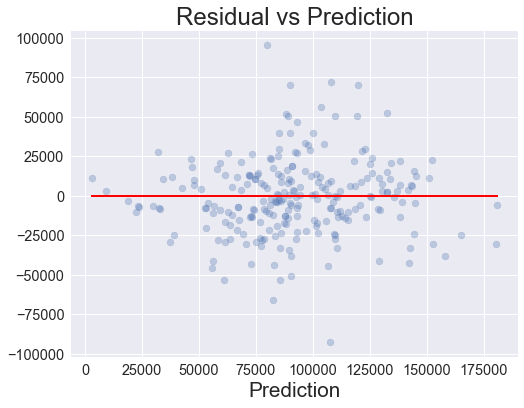

In [52]:
plt.figure(figsize=(8,6))
plt.scatter(y_pred, y_holdout-y_pred, alpha=0.3)
plt.plot(y_pred, [0]*len(y_pred), 'r')
plt.title('Residual vs Prediction', fontsize=24)
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.xlabel('Prediction', fontsize='xx-large');

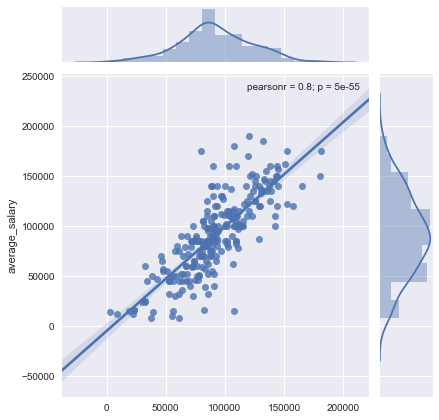

In [53]:
sns.jointplot(y_pred, y_holdout, kind='regplot');

In [54]:
coef_list=[]
for i, j in zip(col,lm.coef_ ):
    coef_list.append((i,j))
len(coef_list)

4284

In [55]:
non_zero = [x for x in coef_list if x[1]!= 0.0 ]
len(non_zero)

549

Total 4284 features used in the model. 549 Features remained after Lasso. To print the top10 positive and negative features

In [56]:
sorted(coef_list, key=lambda x: x[1], reverse=True)[:10]

[('location_San Francisco', 7929.028430480786),
 ('location_Palo Alto', 4483.735811396883),
 ('location_New York City', 3550.300007809017),
 ('title_senior', 3507.3671000359795),
 ('experience', 3355.345279848387),
 ('title_president', 2829.6712535392066),
 ('title_head', 2549.3906065924807),
 ('title_vp', 2513.251100309145),
 ('employees', 2421.0538789033476),
 ('tags_china', 2365.0076948128385)]

In [57]:
sorted(coef_list, key=lambda x: x[1])[:10]

[('location_Berlin', -3459.270330621442),
 ('type_Internship', -3415.452485313717),
 ('title_intern', -3305.026130761517),
 ('location_Paris', -3020.0477570042717),
 ('size_1-10', -2677.138785374904),
 ('title_analyst', -2239.742551552147),
 ('location_London', -2183.227268711077),
 ('location_Bengaluru', -2006.162668711753),
 ('equity_high', -1978.2822536617998),
 ('location_Bangkok', -1961.4573743327644)]